## Load Libraries

In [2]:
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

import torch.nn.functional as F



## Define Hyperparameters

In [3]:
imageSize = 32
batch_size = 128
epochs = 10
device = 'cuda:0'

## Download CIFAR10 dataset

In [4]:
transform = transforms.Compose([
                                    transforms.Resize((imageSize)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

                                ])

train_set = dset.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = dset.CIFAR10(root='../data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

100.0%


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


## Define Teacher network

5 features that we need to make forward code (outputs of colored blocks).

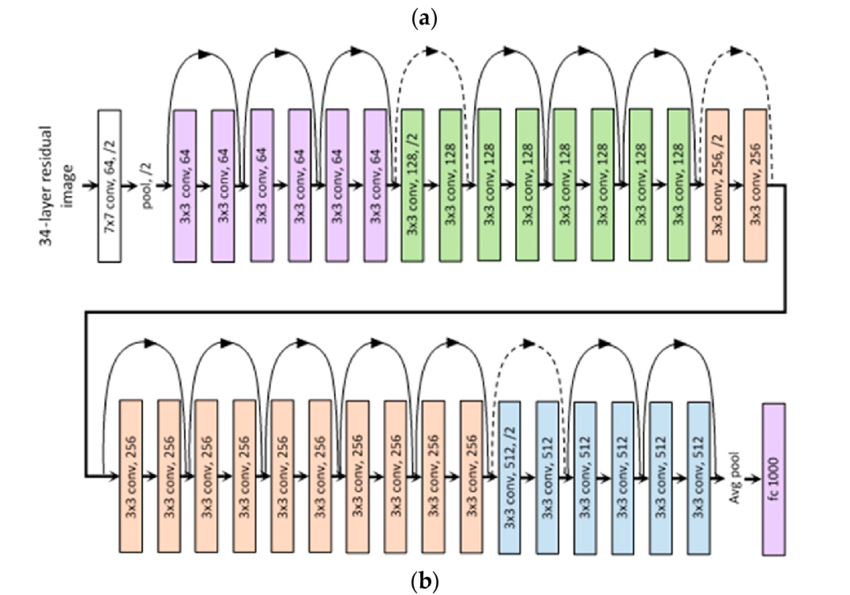

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, name=None):
        super(ResNet, self).__init__()
        self.model_name = name
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        b1 = self.layer2(x)
        b2 = self.layer3(b1)
        b3 = self.layer4(b2)
        pool = F.avg_pool2d(b3, 4)
        pool = pool.view(pool.size(0), -1)
        out = self.linear(pool)
        #out = nn.Softmax()(out)
        return b1,b2,b3,pool,out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes, name='ResNet18')

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes, name='ResNet34')

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes=num_classes, name='ResNet50')

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes=num_classes, name='ResNet101')

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes=num_classes, name='ResNet152')

In [ ]:
model = ResNet34(num_classes=10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) #learning rate


## Train Teacher

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #we do not need the intermediate layers
        _,_,_,_,outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


In [ ]:
from torchsummary import summary

summary(model, (3,32,32))


## Evaluate Teacher

In [ ]:

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        _,_,_,_,outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

## Define Distillation Hyperparameters

In [ ]:
T = 0.5
kd_ratio = 0.7

at_ratio = 1

## Define Distillation Loss

CCE -> student model training y, y^ actual labels
KLDV -> y student output, y^ teacher output


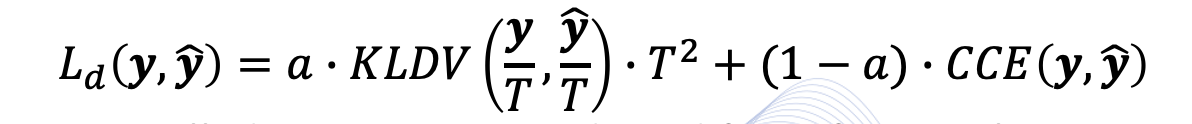

In [ ]:
# avg distill
def distillation_loss(y, labels, y_teacher):
    return nn.KLDivLoss()(F.log_softmax(y/T), y_teacher) * (T*T * 2.0 * kd_ratio) + F.cross_entropy(y, labels) * (1. - kd_ratio)

## Define Student network

In [ ]:
student = ResNet18(num_classes=10)
student.to(device)

## Student training with Soft Labels

In [ ]:
optimizer = optim.SGD(student.parameters(), lr=0.1) #10 times bigger


In [ ]:
acc1 = []
for epoch in range(1, epochs + 1):

    print("\n===> epoch: {}/{}".format(epoch, epochs))


    for i, (input, target) in enumerate(train_loader):

        input = input.view(input.shape[0],3, imageSize,imageSize)

        input, target = input.to(device), target.to(device)

        _,_,_,_,output = student(input)

        with torch.no_grad():
            _,_,_,_,t_output = model(input)


        t_output = F.softmax(t_output/T)


        optimizer.zero_grad()

        kd_loss = distillation_loss(output, target, t_output)
        loss = kd_loss


        loss.backward(retain_graph=True)
        optimizer.step()

        output = output.float()
        loss = loss.float()





    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            _,_,_,_,outputs = student(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc1.append(correct/total)

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Acc: {correct/total}")



## Evaluate Student

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        _,_,_,_,outputs = student(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
student = ResNet18(num_classes=10)
student.to(device)

## Student training with Soft Labels and Hint Maps

(we give hint to the students)

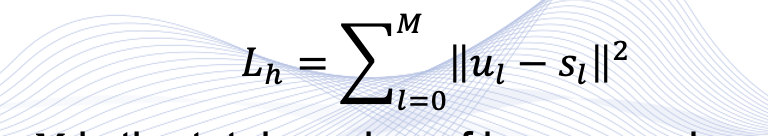

In [ ]:
class AttentionTransfer(nn.Module):
    def forward(self, student, teacher):
        s_attention = F.normalize(student.pow(2).mean(1).view(student.size(0), -1))

        with torch.no_grad():
            t_attention = F.normalize(teacher.pow(2).mean(1).view(teacher.size(0), -1))

        return (s_attention - t_attention).pow(2).mean()

In [ ]:
optimizer = optim.SGD(student.parameters(), lr=0.1)


In [ ]:
acc2 =[]
for epoch in range(1, epochs + 1):
    print("\n===> epoch: {}/{}".format(epoch, epochs))


    for i, (input, target) in enumerate(train_loader):

        input = input.view(input.shape[0],3, imageSize,imageSize)

        input, target = input.to(device), target.to(device)



        b1,b2,b3,pool, output = student(input)

        with torch.no_grad():
            t_b1,t_b2,t_b3, t_pool, t_output = model(input)


        t_output = F.softmax(t_output/T)


        optimizer.zero_grad()

        kd_loss = distillation_loss(output, target, t_output)

        at_criterion = AttentionTransfer().to(device)


        hint_maps = [t_b1,t_b2,t_b3,t_pool]
        st_maps = [b1,b2,b3,pool]

        at_loss = 0
        for idx in range(len(st_maps)):
            at_loss += at_criterion(st_maps[idx], hint_maps[idx])
        at_loss *= at_ratio


        loss = kd_loss + at_loss
        loss.backward(retain_graph=True)
        optimizer.step()

        output = output.float()
        loss = loss.float()



    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            _,_,_,_,outputs = student(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc2.append(correct/total)

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Acc: {correct/total}")


## Evaluate Student

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        _,_,_,_,outputs = student(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

## Compare the two types

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc1, label="Soft-Label")
plt.plot(acc2, label="Soft-Label and Hint Maps")
plt.legend()
plt.show()

## Multi-Teacher Knowledge Distillation

Use model() as teacher1 and train another ResNet as teacher2

Find a way to conbine the two models in a multi teacher distillation setting

## Train Second Teacher

In [ ]:
teacher1 = model
teacher2 = student

student1 = ResNet18(num_classes=10)
#Define the resnet you want dont use large resnets, because it would take a lot of time to get trained
student1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student1.parameters(), lr=0.01)


In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        _,_,_,_,outputs = student1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

## Pefrom Multi-Teacher Distillation

In [ ]:
for epoch in range(1, epochs + 1):
    print("\n===> epoch: {}/{}".format(epoch, epochs))


    for i, (input, target) in enumerate(train_loader):

        input = input.view(input.shape[0],3, imageSize,imageSize)

        input, target = input.to(device), target.to(device)



        b1, b2, b3, pool, output = student1(input)

        with torch.no_grad():
            t1_b1, t1_b2, t1_b3, t1_pool, t1_output = teacher1(input)
            t_2b1, t2_b2, t2_b3, t2_pool, t2_output = teacher2(input)


        t1_output = F.softmax(t1_output/T)
        t2_output = F.softmax(t2_output/T)


        optimizer.zero_grad()

        kd_loss1 = distillation_loss(output, target, t1_output)
        kd_loss2 = distillation_loss(output, target, t2_output)

        at_criterion = AttentionTransfer().to(device)


        hint_maps1 = [t1_b1, t1_b2, t1_b3, t1_pool]
        hint_maps2 = [t2_b1, t2_b2, t2_b3, t2_pool]
        st_maps = [b1, b2, b3, pool]

        at_loss1 = 0
        for idx in range(len(st_maps)):
            at_loss1 += at_criterion(st_maps[idx], hint_maps1[idx])
        at_loss1 *= at_ratio

        at_loss2 = 0
        for idx in range(len(st_maps)):
            at_loss2 += at_criterion(st_maps[idx], hint_maps2[idx])
        at_loss2 *= at_ratio


        loss1 = kd_loss1 + at_loss1
        loss2 = kd_loss2 + at_loss2

        loss = (loss1 + loss2)/2


        loss.backward(retain_graph=True)
        optimizer.step()

        output = output.float()
        loss = loss.float()



    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            _,_,_,_,outputs = student(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc2.append(correct/total)

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Acc: {correct/total}")
